In [212]:
import os
from typing import List, Dict, Optional, Any, Tuple

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

plt.rc("font", family="Arial")


In [213]:
def get_path(method: str, seed: int) -> str:
    return os.path.expanduser(
        os.path.join(
            "~",
            "OneDrive - University of Kentucky",
            "phd",
            "papers",
            "2023_msec_journal",
            f"scores_{method}_{seed:02d}.pt",
        )
    )


In [214]:
def compute_accs(
    groups: List[np.ndarray], group_std: List[np.ndarray]
) -> Dict[str, Any]:
    # Intersection of groups 0 and 1
    mask = groups[0] > groups[1]
    tradeoff_accs = {
        "normal": {"acc": groups[0][mask][0], "std": group_std[0][mask][0]},
        "faulty": {"acc": groups[1][mask][0], "std": group_std[1][mask][0]},
    }
    return tradeoff_accs


In [215]:
def plot_tradeoff(
    labels: List[str],
    scores: torch.Tensor,
    xlim_frac: float = 1.0,
    groups: Optional[List[Dict[str, Any]]] = None,
    ax: Optional[plt.Axes] = None,
    voting: bool = False,
):
    thresholds = np.linspace(scores.min(), xlim_frac * scores.max(), 500)
    has_std = False
    if groups is None:
        # Default is each class separately
        groups = [{"name": x, "members": [x]} for x in set(labels)]
    group_membership = [x["members"] for x in groups]

    group_acc = [np.zeros_like(thresholds) for _ in group_membership]
    group_std = [np.zeros_like(thresholds) for _ in group_membership]
    for i, x in enumerate(thresholds):
        preds = (scores > x).long()
        actual = torch.tensor([l != "normal" for l in labels])
        for j, group in enumerate(group_membership):
            mask = torch.tensor([l in group for l in labels])
            if len(preds.shape) > 1:
                # Multiple predictions, compute acc mean and std
                has_std = not voting
                if voting:
                    voted = preds[mask].long().sum(-1) > preds.shape[-1] / 2
                    group_acc[j][i] = (
                        voted == actual[mask]
                    ).float().sum() / voted.shape[0]
                else:
                    ensemble = (
                        preds[mask]
                        == actual[mask].unsqueeze(-1).tile((1, preds.shape[-1]))
                    ).float().sum(0) / preds[mask].shape[0]
                    # print(ensemble)
                    group_acc[j][i] = ensemble.mean()
                    group_std[j][i] = ensemble.std()

            else:
                group_acc[j][i] = (preds[mask] == actual[mask]).float().sum() / preds[
                    mask
                ].shape[0]

    if ax is None:
        _, ax = plt.subplots(dpi=300, figsize=(6.5, 5))

    ax.set_clip_on(False)
    colors = [
        "forestgreen",
        "navy",
        "dodgerblue",
        "orange",
        "coral",
        "cadetblue",
        "brown",
        "black",
    ]
    for i, group in enumerate(groups):
        ax.plot(
            thresholds,
            group_acc[i],
            color=colors[i],
            lw=2,
            ls="--",
            label=group["name"],
            clip_on=False,
        )
        if has_std:
            ax.fill_between(
                thresholds,
                np.clip(group_acc[i] + group_std[i], a_max=1.0, a_min=0.0),
                np.clip(group_acc[i] - group_std[i], a_max=1.0, a_min=0.0),
                color=colors[i],
                alpha=0.35,
                lw=0,
                clip_on=False,
            )
    ax.set_xlabel("Score Threshold")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(thresholds.min(), thresholds.max())
    ax.legend()
    return group_acc, group_std, thresholds


In [216]:
groups = [
    {"name": "Normal", "members": ["normal"]},
    {
        "name": "Faulty",
        "members": [
            "faulted_bearings",
            "rotor_broken",
            "rotor_bowed",
            "rotor_unbalance",
            "rotor_misalignment",
            "voltage_unbalance",
            "phase_loss",
        ],
    },
]
voting = False


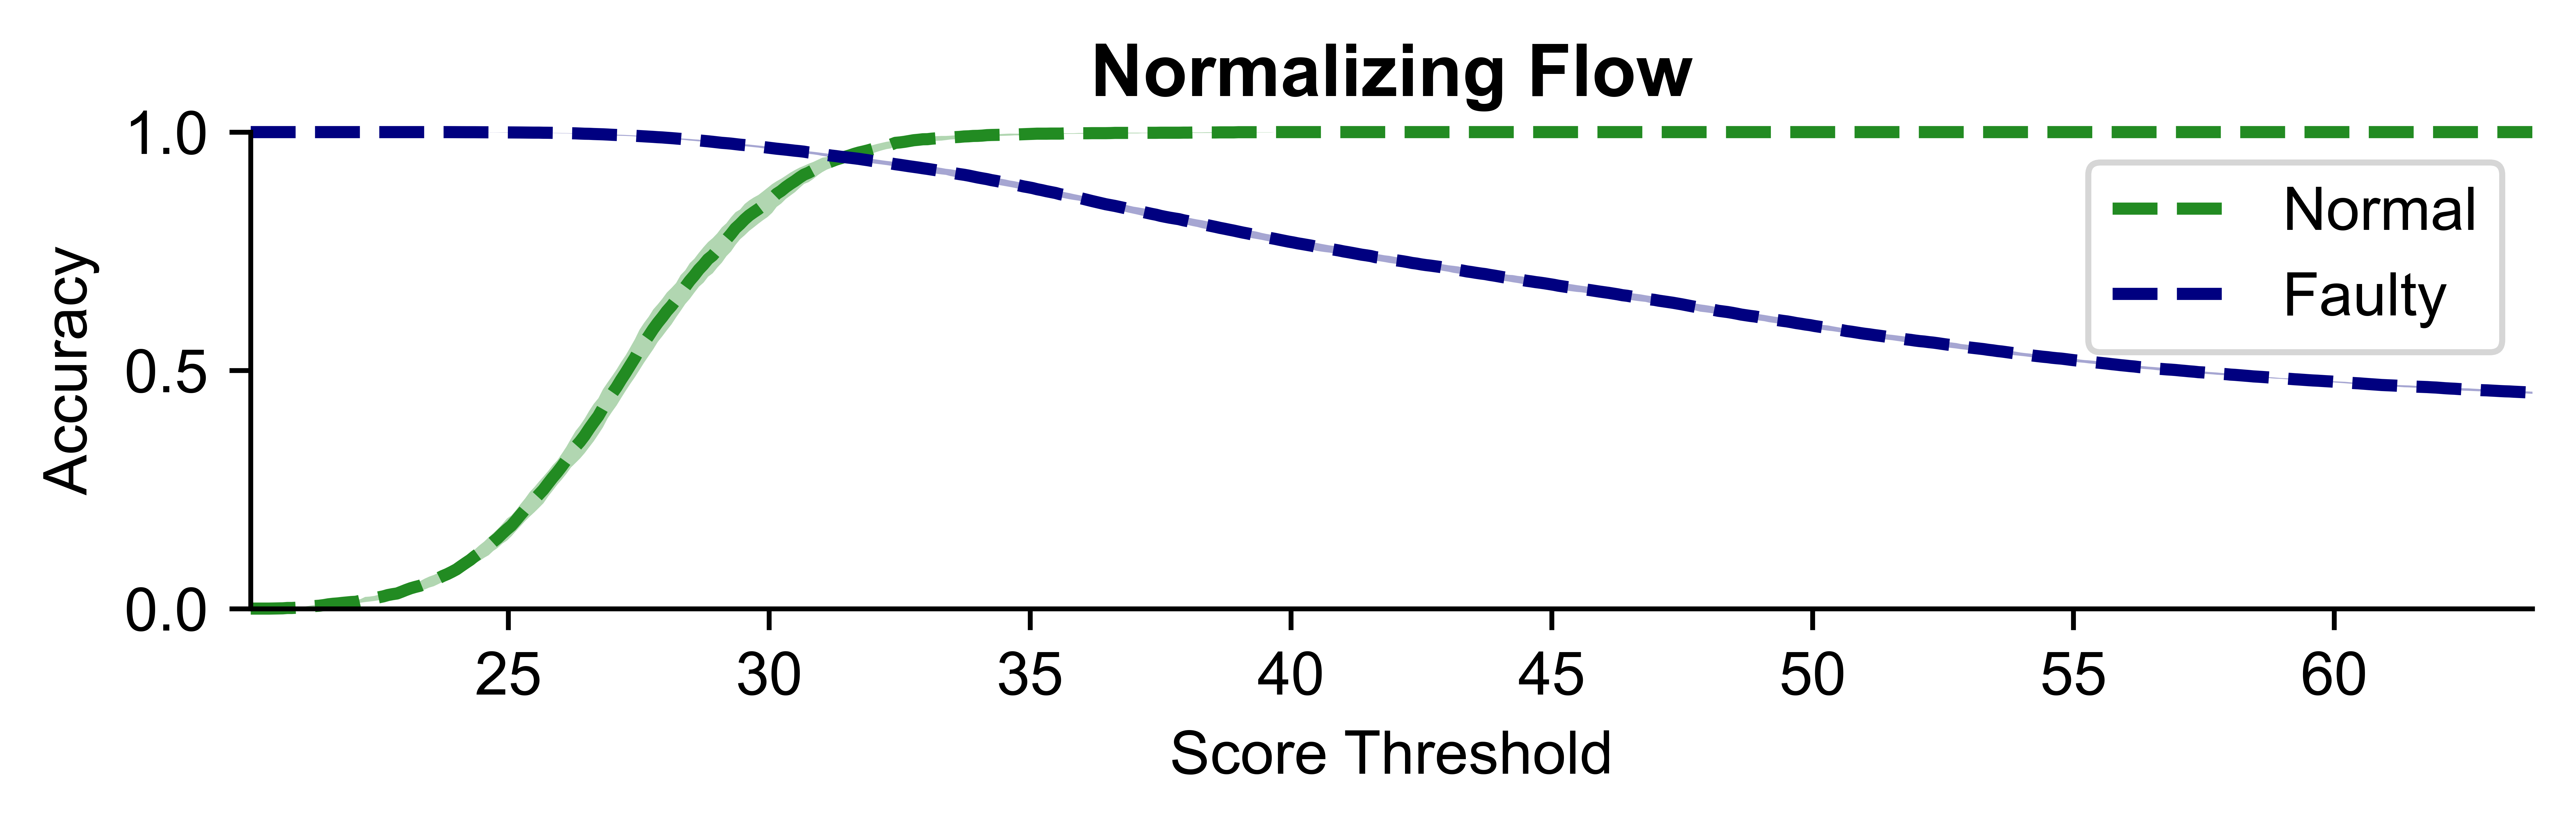

{'normal': {'acc': 0.9483043551445007, 'std': 0.010136506520211697},
 'faulty': {'acc': 0.9473191499710083, 'std': 0.0035806922242045403}}

In [227]:
flow_results = [torch.load(get_path("flow", i)) for i in range(5)]
fig, ax = plt.subplots(dpi=1500, figsize=(6, 2))
flow_acc, flow_std, flow_thresholds = plot_tradeoff(
    flow_results[0]["labels"],
    torch.stack([x["scores"] for x in flow_results], dim=-1),
    xlim_frac=0.005,
    groups=groups,
    ax=ax,
)
ax.set_title("Normalizing Flow", fontweight="bold")
fig.tight_layout()
fig.savefig("thresh-flow.jpg", bbox_inches="tight")
plt.show()
flow_intersect_idx = (flow_acc[0] < flow_acc[1]).astype(int).sum()
flow_thresh = flow_thresholds[flow_intersect_idx]
compute_accs(flow_acc, flow_std)


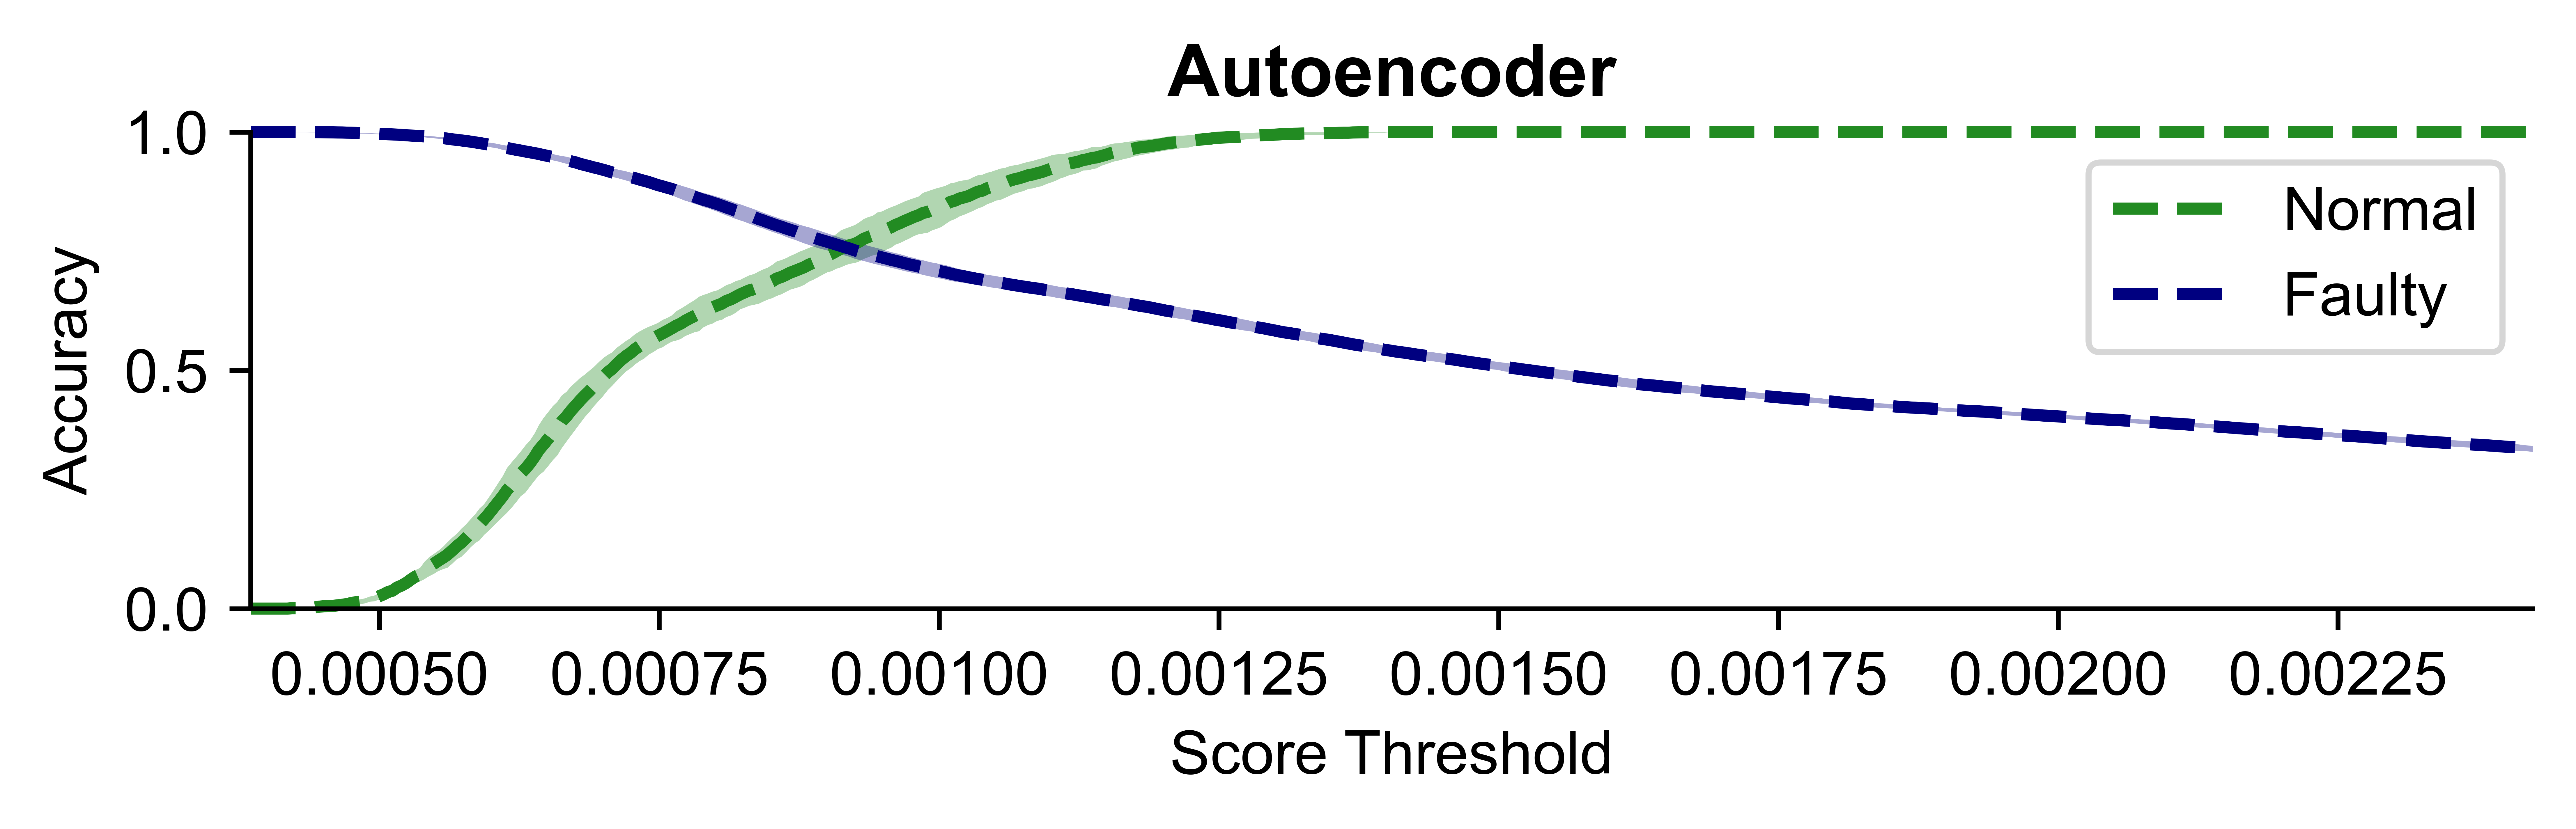

{'normal': {'acc': 0.7593033909797668, 'std': 0.038549136370420456},
 'faulty': {'acc': 0.7581942677497864, 'std': 0.017058059573173523}}

In [229]:
ae_results = [torch.load(get_path("ae", i)) for i in range(5)]
fig, ax = plt.subplots(dpi=1500, figsize=(6, 2))
ae_acc, ae_std, ae_thresholds = plot_tradeoff(
    ae_results[0]["labels"],
    torch.stack([x["scores"] for x in ae_results], dim=-1),
    0.05,
    groups,
    ax,
)
ax.set_title("Autoencoder", fontweight="bold")
fig.tight_layout()
fig.savefig("thresh-ae.jpg", bbox_inches="tight")
plt.show()
ae_intersect_idx = (ae_acc[0] < ae_acc[1]).astype(int).sum()
ae_thresh = ae_thresholds[ae_intersect_idx]
compute_accs(ae_acc, ae_std)


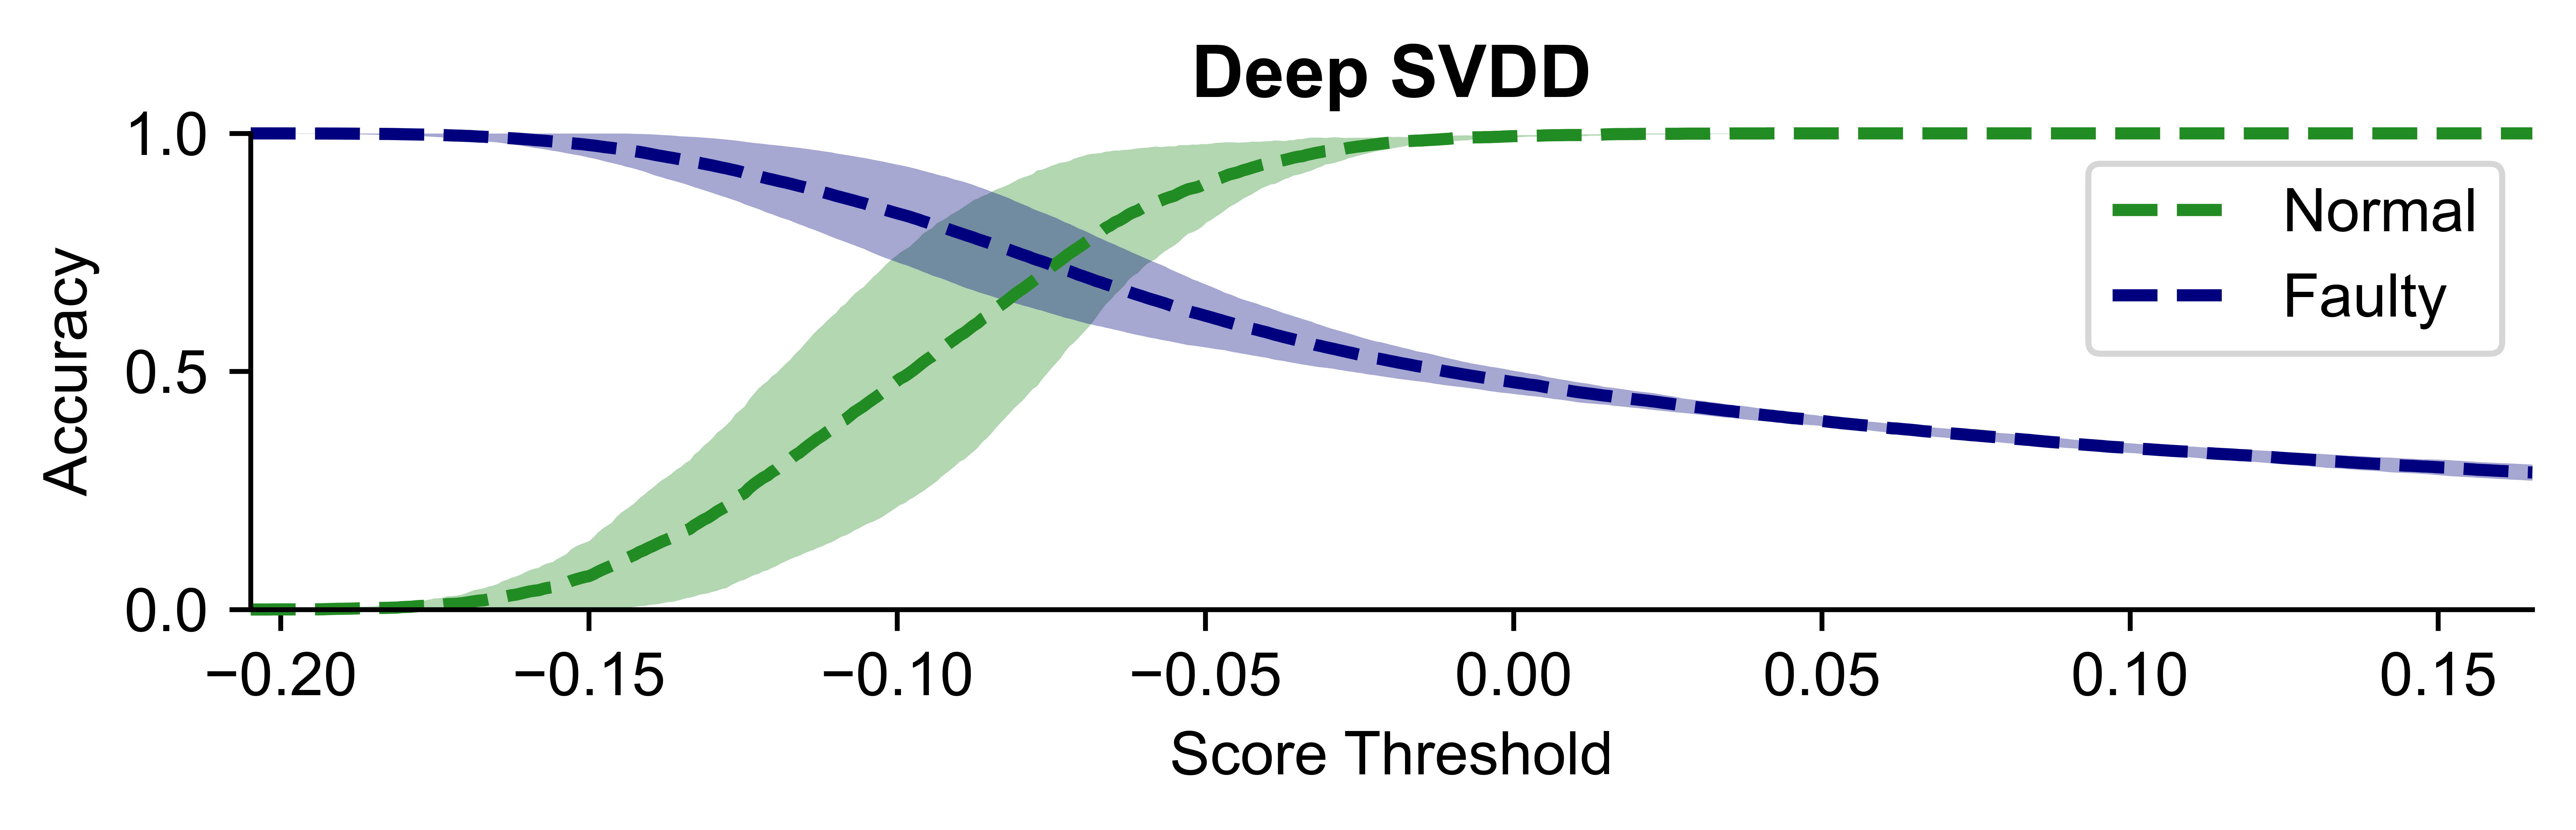

{'normal': {'acc': 0.7257562279701233, 'std': 0.20907442271709442},
 'faulty': {'acc': 0.7212443351745605, 'std': 0.10194825381040573}}

In [238]:
deepsvdd_results = [torch.load(get_path("deepsvdd_es", i)) for i in range(5)]
fig, ax = plt.subplots(dpi=1500, figsize=(6, 2))
deepsvdd_acc, deepsvdd_std, deepsvdd_thresholds = plot_tradeoff(
    deepsvdd_results[0]["labels"],
    torch.stack([x["scores"] for x in deepsvdd_results], dim=-1),
    0.02,
    groups,
    ax,
)
ax.set_title("Deep SVDD", fontweight="bold")
fig.tight_layout()
fig.savefig("thresh-deepsvdd.jpg", bbox_inches="tight")
plt.show()
deep_svdd_intersect_idx = (deepsvdd_acc[0] < deepsvdd_acc[1]).astype(int).sum()
deep_svdd_thresh = deepsvdd_thresholds[deep_svdd_intersect_idx]
compute_accs(deepsvdd_acc, deepsvdd_std)


In [236]:
def bar_graph(
    threshold: float,
    scores: torch.Tensor,
    labels: List[str],
    label_order: List[str],
    ax: plt.Axes,
    offset: float = 0,
    barw: float = 0.7,
    color: Optional[str] = None,
):
    accs = []
    stds = []
    for c in label_order:
        mask = torch.tensor([x == c for x in labels])
        class_scores = scores[mask]
        class_preds = class_scores > threshold
        actual = (
            torch.zeros_like(class_preds, dtype=torch.bool)
            if c == "normal"
            else torch.ones_like(class_preds, dtype=torch.bool)
        )
        acc = (class_preds == actual).float().sum(0) / class_scores.shape[0]
        accs.append(acc.mean().item())
        stds.append(acc.std().item())
    print(accs)
    print(stds)
    x = np.arange(len(label_order)) + offset
    ax.bar(x, accs, width=barw, alpha=1.0, color=color)
    ax.set_ylim(0, 1)
    ax.errorbar(x, accs, stds, fmt="none", color="k", capsize=2, lw=0.75, clip_on=False)
    ax.set_ylabel("Accuracy")
    ax.set_xticks(x)
    ax.set_xticklabels(label_order, rotation=45)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


[0.9483043551445007, 1.0, 1.0, 1.0, 0.9754749536514282, 0.675000011920929, 0.9854480624198914, 1.0]
[0.010136506520211697, 0.0, 0.0, 0.0, 0.0064217629842460155, 0.011553701013326645, 0.012175911106169224, 0.0]
[0.7593033909797668, 1.0, 0.9827618598937988, 1.0, 0.4818653166294098, 0.233216792345047, 0.6338952779769897, 0.9966812133789062]
[0.038549136370420456, 0.0, 0.006474243476986885, 0.0, 0.04944952577352524, 0.028495699167251587, 0.03890836611390114, 0.0012954159174114466]
[0.7257562279701233, 0.9998267292976379, 0.7271547913551331, 0.9825612902641296, 0.39430052042007446, 0.2786713242530823, 0.7132209539413452, 0.9643667936325073]
[0.20907442271709442, 0.00038752504042349756, 0.13021333515644073, 0.012542614713311195, 0.22070840001106262, 0.21168506145477295, 0.13549508154392242, 0.021846288815140724]


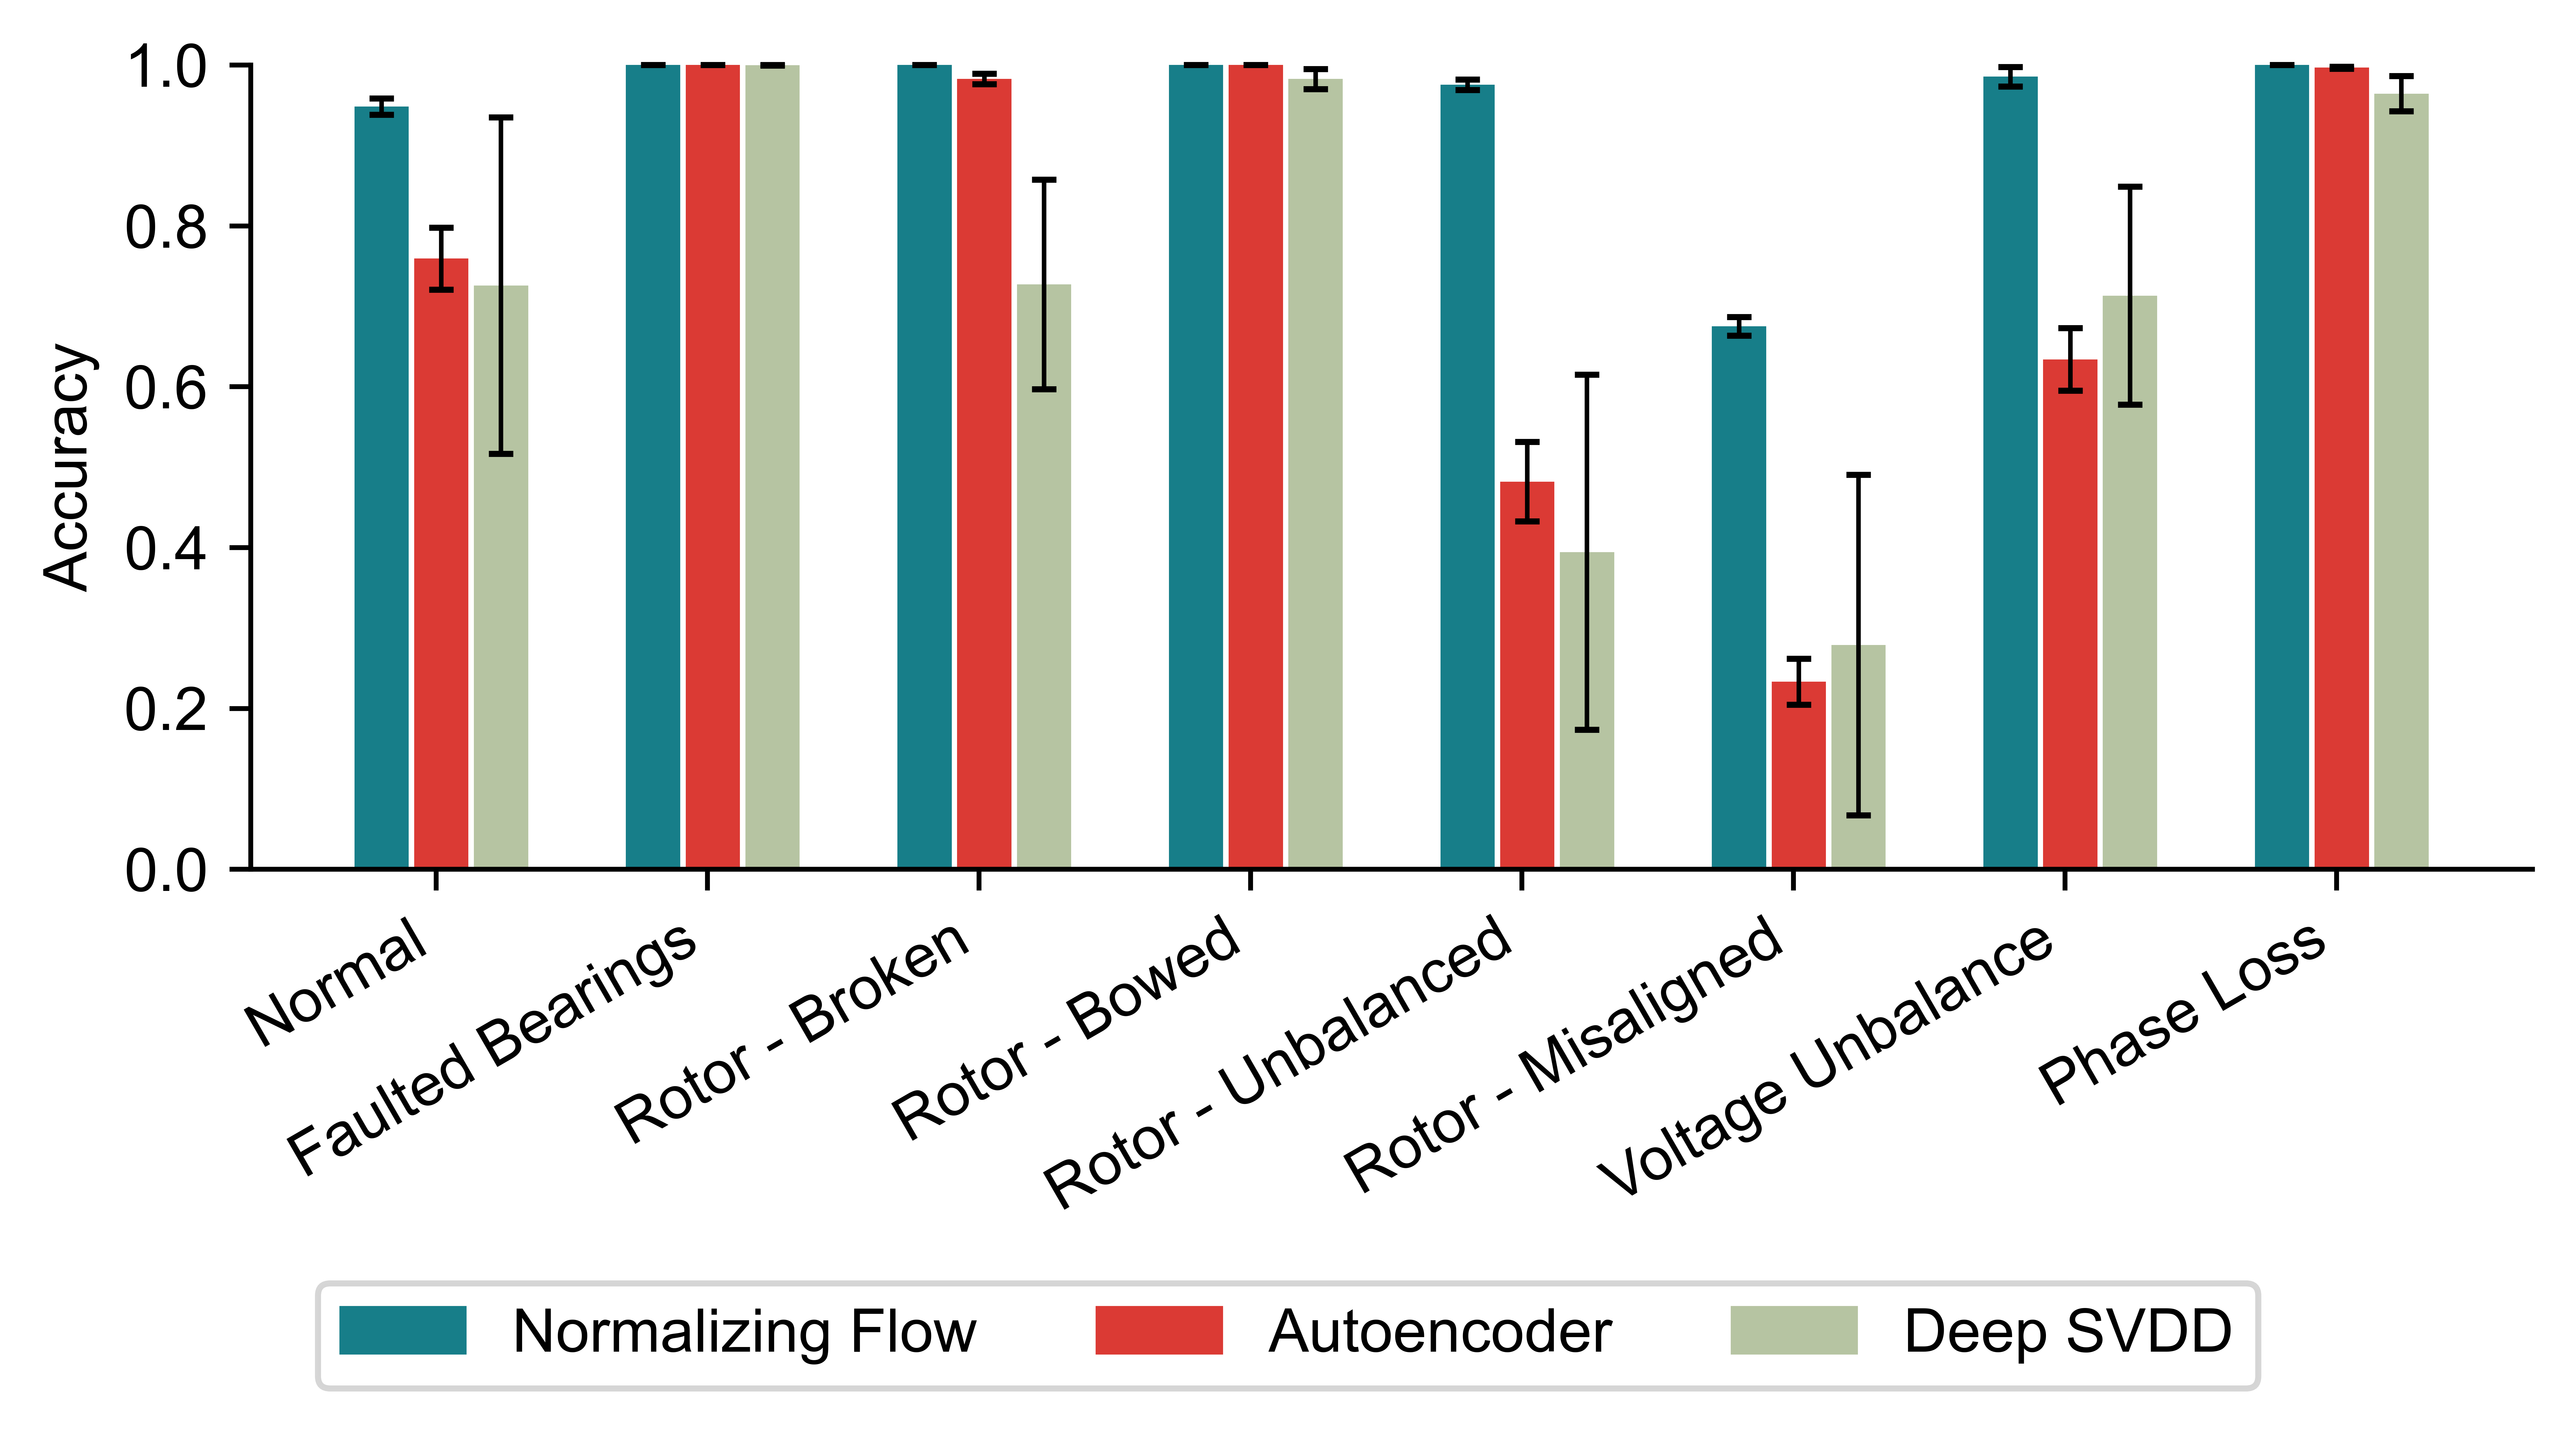

In [237]:
fig, ax = plt.subplots(dpi=1500, figsize=(6, 3))
labels = [
    "Normal",
    "Faulted Bearings",
    "Rotor - Broken",
    "Rotor - Bowed",
    "Rotor - Unbalanced",
    "Rotor - Misaligned",
    "Voltage Unbalance",
    "Phase Loss",
]
bar_graph(
    flow_thresh,
    torch.stack([x["scores"] for x in flow_results], dim=-1),
    flow_results[0]["labels"],
    ["normal"] + groups[1]["members"],
    ax=ax,
    barw=0.2,
    color="#177E89",
)
bar_graph(
    ae_thresh,
    torch.stack([x["scores"] for x in ae_results], dim=-1),
    ae_results[0]["labels"],
    ["normal"] + groups[1]["members"],
    ax=ax,
    barw=0.2,
    offset=0.22,
    color="#DB3A34",
)
bar_graph(
    deep_svdd_thresh,
    torch.stack([x["scores"] for x in deepsvdd_results], dim=-1),
    deepsvdd_results[0]["labels"],
    ["normal"] + groups[1]["members"],
    ax=ax,
    barw=0.2,
    offset=0.44,
    color="#B6C4A2",
)
ax.set_xticks(np.arange(len(labels)) + 0.2)
ax.set_xticklabels(labels, rotation=30, fontdict=dict(ha="right"))
fig.legend(
    handles=[
        mpl.patches.Patch(color="#177E89", label="Normalizing Flow"),        
        mpl.patches.Patch(color="#DB3A34", label="Autoencoder"),
        mpl.patches.Patch(color="#B6C4A2", label="Deep SVDD"),
    ],
    loc="lower center",
    bbox_to_anchor=[0.5, -0.1],
    ncol=3

)
fig.tight_layout()
fig.savefig("ad-acc.jpg", bbox_inches="tight")
plt.show()
